# Configurations

In [1]:
import os
import torch
import lightning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Any, Optional, Tuple

from mlcolvar.cvs import BaseCV,VariationalAutoEncoderCV
from mlcolvar.core.loss.mse import mse_loss
from mlcolvar.core import FeedForward, Normalization
from mlcolvar.core.transform.utils import Inverse
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))


torch.manual_seed(41)

In [13]:
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.data import DictModule
from mlcolvar.utils.timelagged import create_timelagged_dataset

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR",
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]
n_states = len(filenames)

dataset, df = create_dataset_from_files(
    filenames,
	filter_args={'regex':'d_' }, # select distances between heavy atoms
	create_labels=True,
	return_dataframe=True,
)


X = df.filter(regex='d_').values
dataset = create_timelagged_dataset(X,lag_time=1)
datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

/home/shpark/.conda/envs/cmd/lib/python3.9/site-packages/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(


In [10]:
df.shape

(10002, 53)

In [12]:
dataset

DictDataset( "data": [9999, 45], "data_lag": [9999, 45], "weights": [9999], "weights_lag": [9999] )

In [19]:
X

array([[0.152064, 0.233505, 0.241173, ..., 0.227324, 0.281913, 0.148169],
       [0.155185, 0.240708, 0.248149, ..., 0.224891, 0.277797, 0.147678],
       [0.153066, 0.234474, 0.243036, ..., 0.232262, 0.299267, 0.14968 ],
       ...,
       [0.156518, 0.240429, 0.245153, ..., 0.221728, 0.279992, 0.146046],
       [0.153141, 0.239219, 0.247953, ..., 0.225136, 0.300626, 0.148922],
       [0.148242, 0.240686, 0.241408, ..., 0.224406, 0.283972, 0.149084]])

# Load model

In [5]:
from mlcolvar.cvs import DeepTICA

n_components = 1
nn_layers = [45, 15, 15, 5]
options= {'nn': {'activation': 'shifted_softplus'} }

model = DeepTICA(nn_layers, n_cvs=n_components, options=options)

# Visualization

In [14]:
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i]

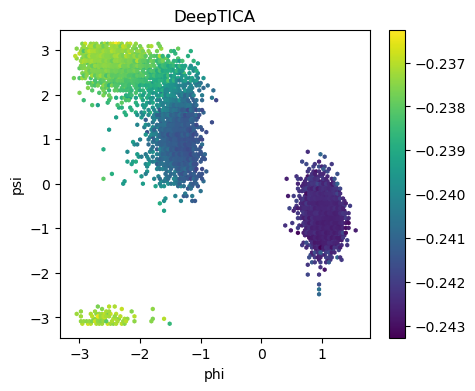

In [15]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax)
    ax.set_title(f'DeepTICA')

In [16]:
max_cv0 = df['CV0'].max()
min_cv0 = df['CV0'].min()
boundary = np.linspace(min_cv0, max_cv0, 10)
boundary

array([-0.2439349 , -0.24308104, -0.24222719, -0.24137333, -0.24051947,
       -0.23966562, -0.23881176, -0.2379579 , -0.23710405, -0.23625019])

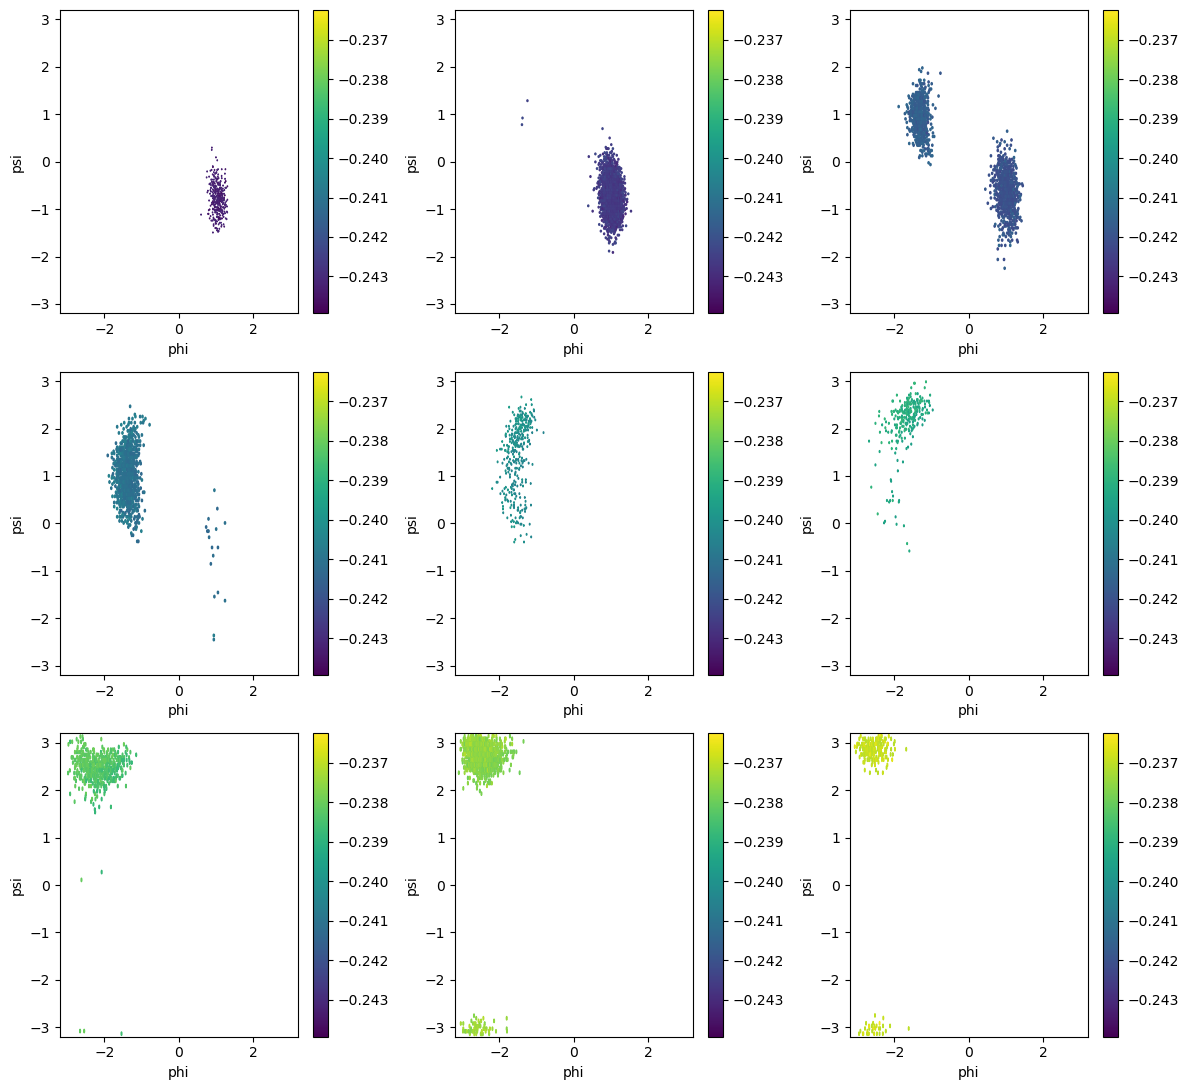

In [17]:
fig,axs = plt.subplots(3, 3, figsize = ( 12, 11 ) )
axs = axs.ravel()

for i in range(0, min(len(boundary)-1, 9)):
	ax = axs[i]
	df_selected = df[(df[f'CV0'] <= boundary[i+1]) & (df[f'CV0'] >= boundary[i])]
	if len(df_selected) == 0:
		continue
	df_selected.plot.hexbin(
		'phi', 'psi', C=f'CV0',
  		vmin=boundary[0], vmax=boundary[-1],
    	cmap='viridis', ax=ax
    )
	# ax.set_title(f'CV value in [{boundary[i]:.2f},{boundary[i+1]:.2f}]')
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
plt.tight_layout()

## More data points

In [15]:
more_data = torch.load("../../../data/alanine/heavy_atom_distance.pt")
more_data.shape

torch.Size([1000000, 45])

In [16]:
with torch.no_grad():
    s = model(more_data).numpy()
    
new_df = pd.DataFrame(s, columns=[f'CV{i}' for i in range(n_components)])
new_df

,CV0
0,0.000058
1,-0.000136
2,-0.000034
3,0.000018
4,-0.000932
...,...
999995,-0.017514
999996,-0.031795
999997,0.009143
999998,-0.026302


In [17]:
psis = np.load("../../../data/alanine/heavy_atom_distance_psis.npy")
phis = np.load("../../../data/alanine/heavy_atom_distance_phis.npy")
new_df['psi'] = psis
new_df['phi'] = phis
new_df

,CV0,psi,phi
0,0.000058,2.724753,-2.496995
1,-0.000136,2.714459,-2.490017
2,-0.000034,2.701140,-2.479672
3,0.000018,2.702199,-2.466322
4,-0.000932,2.717623,-2.420580
...,...,...,...
999995,-0.017514,2.619246,-1.407471
999996,-0.031795,2.730429,-1.359652
999997,0.009143,2.644886,-1.330804
999998,-0.026302,2.551387,-1.297497


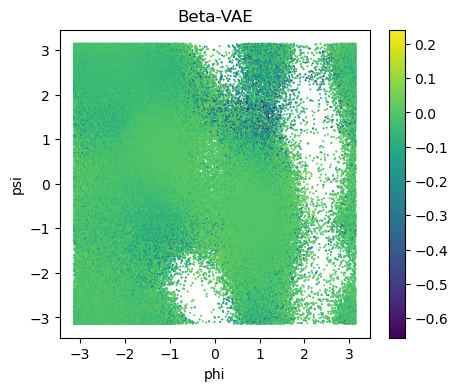

In [21]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    new_df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax, gridsize=400)
    ax.set_title(f'Beta-VAE')

In [19]:
max_cv0 = new_df['CV0'].max()
min_cv0 = new_df['CV0'].min()
boundary = np.linspace(min_cv0, max_cv0, 10)
boundary

array([-0.72640693, -0.58149946, -0.436592  , -0.29168453, -0.14677706,
       -0.00186959,  0.14303788,  0.28794534,  0.43285281,  0.57776028])

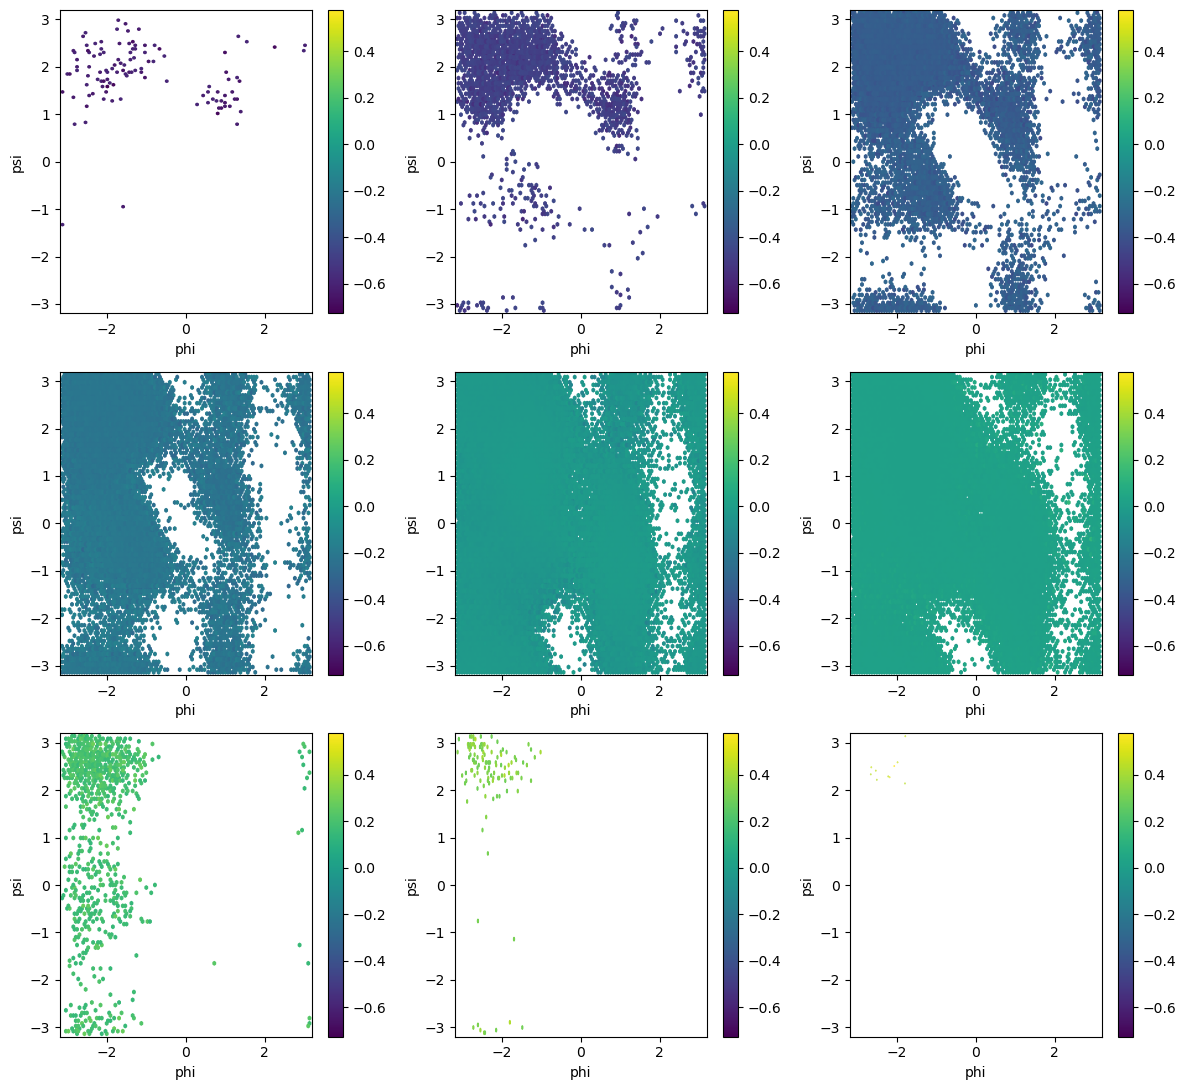

In [20]:
fig,axs = plt.subplots(3, 3, figsize = ( 12, 11 ) )
axs = axs.ravel()

for i in range(0, min(len(boundary)-1, 9)):
	ax = axs[i]
	new_df_selected = new_df[(new_df[f'CV0'] <= boundary[i+1]) & (new_df[f'CV0'] >= boundary[i])]
	if len(new_df_selected) == 0:
		continue
	new_df_selected.plot.hexbin(
		'phi', 'psi', C=f'CV0',
  		vmin=boundary[0], vmax=boundary[-1],
    	cmap='viridis', ax=ax
    )
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
plt.tight_layout()